# Data Science Internship
Candidato: Thaísa Adila Maranha

Apliquei esse modelo para entender quais são as características dos dados análisados. Assim, pude perceber que as avaliações positivas um valor de sentimento maior do que as avaliações negativas. Sendo assim, iriei analisar as palavras neutras, para entender o que de fato tem agradado ou não os clientes. 

In [2]:
import pandas as pd

reviews_df = pd.read_csv("C:/Users/thais/tech_test.tsv")
reviews_df["is_bad_review"] = reviews_df["review_user_rating"].apply(lambda x: 1 if x < 5 else 0)
reviews_df = reviews_df[["review_body", "is_bad_review"]]
reviews_df.head()

,review_body,is_bad_review
0,Pros: fingerprint resistant so you don't have ...,1
1,Pros: fingerprint resistant so you don't have ...,1
2,Feels solid and âupscaleâ. Excellent desig...,0
3,I love this fridge. So much room over having a...,0
4,I love this fridge. So much room over having a...,0


In [3]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

In [4]:
reviews_df["review_body"] = reviews_df["review_body"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))


In [5]:
# retorna o valor do objeto wordnet correspondente à POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # texto mais baixo
    text = text.lower()
    # tokenize texto e remover pontuação
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove palavras que contenham números
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove palavras irrelevantes
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove tokens vazios
    text = [t for t in text if len(t) > 0]
    # pos tag texto
    pos_tags = pos_tag(text)
    # lemmatize texto
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remover palavras com apenas uma letra
    text = [t for t in text if len(t) > 1]
    # juntar todos
    text = " ".join(text)
    return(text)

# dados de texto limpo
reviews_df["review_clean"] = reviews_df["review_body"].apply(lambda x: clean_text(x))

In [6]:
# adicionar colunas de análise de sentimentos
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review_body"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [7]:
# adicionar coluna de número de caracteres
reviews_df["nb_chars"] = reviews_df["review_body"].apply(lambda x: len(x))

# adicionar coluna de número de palavras
reviews_df["nb_words"] = reviews_df["review_body"].apply(lambda x: len(x.split(" ")))

In [8]:
# criar colunas do vetor doc2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# treinar um modelo Doc2Vec com nossos dados de texto
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [9]:
# adicionar colunas tf-idfs
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [10]:
# mostre a distribuição is_bad_review
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.569614
1    0.430386
Name: is_bad_review, dtype: float64

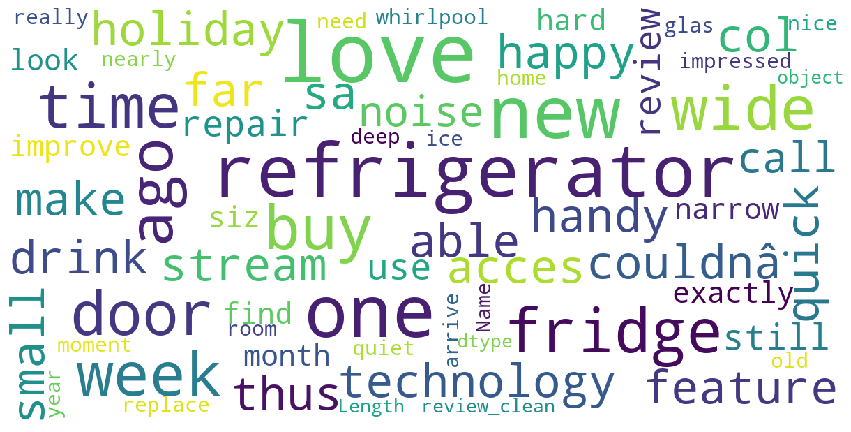

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        collocations=False,
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# mostrar wordcloud
show_wordcloud(reviews_df["review_clean"])

In [12]:
# análises de sentimentos positivos mais altos (com mais de 5 palavras)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review_clean", "pos"]].head(10)

,review_clean,pos
18791,clean line nice appearance good seal door easy...,0.510
640,great fridge price love room pull bottom freez...,0.484
6165,buy month ago i'm happy light excellent love s...,0.480
7302,far good energy feature make slow reach desire...,0.479
7301,far good energy feature make slow reach desire...,0.479
8374,absolutely love fridge massive love french doo...,0.478
10562,love love love fridge everything love outside ...,0.464
9626,love love love frig slide shelve amazing clear...,0.461
13431,iâve fridge week love itâs nice roomy love...,0.457
11247,purchase delivery new lg refrigerator great is...,0.455


In [13]:
# avaliações de sentimentos negativos mais baixos (com mais de 5 palavras)

reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review_clean", "neg"]].head(10)

,review_clean,neg
18625,buy frigidaire fail less year fail stay cool f...,0.301
11325,numerous repair frigidaire unable repair unit\...,0.271
438,fridge small cost fridge store super impressed...,0.260
1534,problem ice maker water leak tray freezes cube...,0.251
1535,problem ice maker water leak tray freezes cube...,0.251
4413,unable level door month one frig side door she...,0.249
6790,hard type hand numb peck one finger review col...,0.248
16296,three month compressor already fail buy model ...,0.245
4574,snag still love low freezer much easy make ref...,0.236
14127,fridge month happier great use space auto fill...,0.232


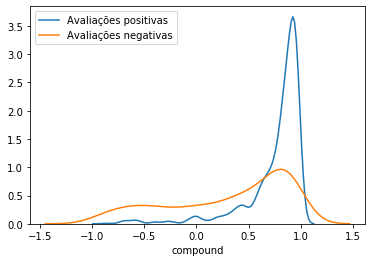

In [22]:
# distribuição de sentimentos para críticas positivas e negativas

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Desenhar o gráfico de densidade
    if x == 0:
        label = "Avaliações positivas"
    else:
        label = "Avaliações negativas"
    sns.distplot(subset['compound'], hist = False, label = label)

In [15]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review_body", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# dividir os dados em treinar e testar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)


In [25]:
# treinar um random forest classifier
rf = RandomForestClassifier(n_estimators = 5000, random_state = 42)
rf.fit(X_train, y_train)

# mostrar recursos importantes
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.062621
2,pos,0.055578
0,neg,0.033578
392,word_love,0.030538
1,neu,0.028528
6,doc2vec_vector_0,0.017110
4,nb_chars,0.014588
8,doc2vec_vector_2,0.013992
289,word_great,0.013765
5,nb_words,0.013383


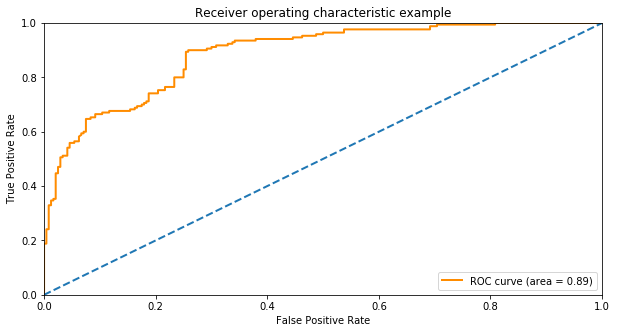

In [26]:
# ROC curva

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (10, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

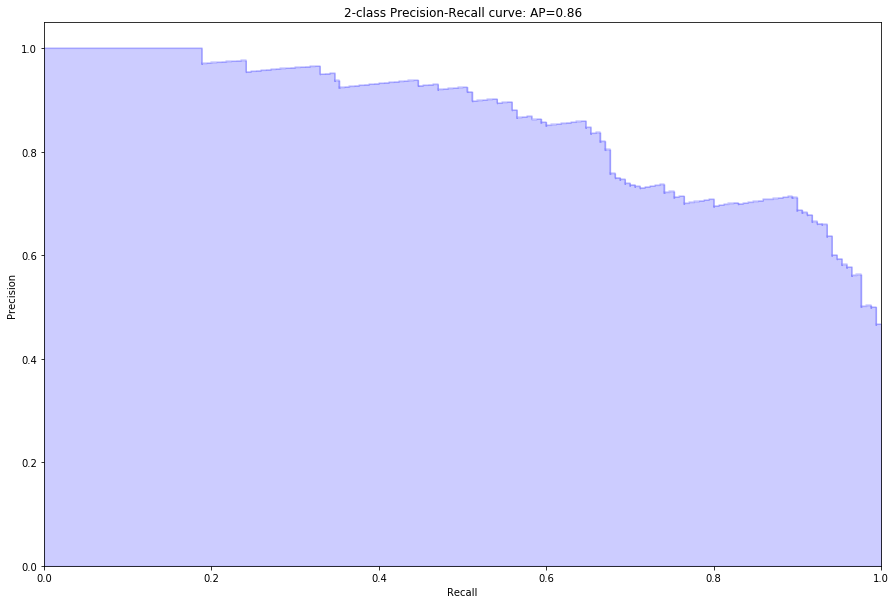

In [27]:
# PR curva
from inspect import signature
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# No matplotlib <1.5, o plt.fill_between não possui um argumento 'step'
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))